# Base Case: Circular Orbit of Radius 1 AU, Period 1 Year

Create synthetic data for the simplest base case: a circular orbit of radius 1.

Can think of this as approximating the earth: radius = 1 AU, period = 1 year, mass of sun $m_0$ = 1 solar mass

\begin{align}
x(t) &= \cos(\omega t) \\
y(t) &= \sin(\omega t) \\
\omega &= 2 \pi
\end{align}

Taking two derivatives
\begin{align}
\ddot{x}(t) = -\omega^2 x(t)\\
\ddot{y}(t) = -\omega^2 y(t)
\end{align}

Equating the acceleration $\omega^2 r$ to $G \cdot m_0 / r^2$ for $r=1$ in the case of earth, we can see that in these units the gravitational constant $G$ is
$$G = 4 \pi^2$$

Further we can see that for a planet in a circular orbit with radius $r$, the angular frequency will satisfy
$$ \omega^2 = G m_0 / r^3$$
This is a special case of Kepler's third law.

In [1]:
# Library imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import load_vartbl, save_vartbl, plot_style
from tf_utils import gpu_grow_memory, TimeHistory
from tf_utils import Identity

from r2b_data import make_traj_r2bc , make_train_r2bc
from r2b_data import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy
from r2b_data import make_datasets_earth, make_datasets_solar, make_datasets_r2bc

from r2b import KineticEnergy_R2B, PotentialEnergy_R2B
from r2b import AngularMomentum0_R2B, AngularMomentum_R2B
from r2b import ConfigToPolar2D
from r2b import Motion_R2B, Position_R2BC_Math

from r2bc_model import make_model_r2bc_math, make_model_r2b

In [3]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [4]:
# Create distribution strategy
# This isn't working properly for training in Michael-PC (Windows 10)
# but does work for evaluating (with no real benefit though)
# strat = tf.distribute.MirroredStrategy(['/GPU:0', '/GPU:1'])

# Plot style 
plot_style()

In [5]:
# Lightweight serialization
fname = '../pickle/r2bc.pickle'
vartbl = load_vartbl(fname)

In [6]:
# One trajectory of earth for plotting
inputs_earth, outputs_earth = make_traj_r2bc(r0=1.0, theta0=0.0, n_years=2)

# Combined dict
data_earth = {**inputs_earth, **outputs_earth}

In [7]:
# fig, ax = plot_orbit_q(data_earth)

In [8]:
# fig, ax = plot_orbit_v(data_earth)

In [9]:
# fig, ax = plot_orbit_a(data_earth)

In [10]:
# fig, ax = plot_orbit_energy(data_earth)

In [11]:
# Create DataSet objects for toy size problem - earth orbits only (a=1, e=0)
ds_earth_trn, ds_earth_val, ds_earth_tst = make_datasets_earth(n_traj=1000, vt_split=0.20)

# Create DataSet objects for solar system type orbits (a between 0.25 and 32.0)
ds_solar_trn, ds_solar_val, ds_solar_tst = make_datasets_solar(n_traj=10000, vt_split=0.20)

# Create DataSet objects for jupiter orbits only (a=5.2, e=0)
ds_jup_trn, ds_jup_val, ds_jup_tst = make_datasets_r2bc(n_traj=1000, vt_split=0.20, 
                                                        n_years=2, r_min=5.2, r_max=5.2, seed=42, batch_size=64)

In [12]:
# Example batch
batch_in, batch_out = list(ds_earth_val.take(1))[0]
# batch_in.keys()
# batch_out.keys()

t = batch_in['t']
q0 = batch_in['q0']
v0 = batch_in['v0']
mu = batch_in['mu']

q = batch_out['q']
v = batch_out['v']
a = batch_out['a']

print(f'Example batch sizes:')
print(f't  = {t.shape}')
print(f'q0 = {q0.shape}')
print(f'v0 = {v0.shape}')
print(f'mu = {mu.shape}')

print(f'q  = {q.shape}')
print(f'v  = {v.shape}')
print(f'a  = {a.shape}')

Example batch sizes:
t  = (64, 731)
q0 = (64, 2)
v0 = (64, 2)
mu = (64, 1)
q  = (64, 731, 2)
v  = (64, 731, 2)
a  = (64, 731, 2)


In [13]:
batch_size = 64
traj_size = 731

tf.debugging.assert_shapes({
    t: (batch_size, traj_size),
    q0: (batch_size, 2),
    v0: (batch_size, 2),
    mu: (batch_size, 1),
    q: (batch_size, traj_size, 2),
    v: (batch_size, traj_size, 2),
    a: (batch_size, traj_size, 2)
})

In [14]:
class PotentialEnergy_R2B(keras.layers.Layer):
    """Compute the potential energy from position q and gravitational constant mu"""
    def call(self, inputs):
        # Unpack inputs
        q, mu = inputs

        # Shape of q is (batch_size, traj_size, 2,)
        # Shape of mu is (batch_size, 1)
        # batch_size, traj_size = q.shape[0:2]
        # tf.debugging.assert_shapes({
        #     q: (batch_size, traj_size, 2),
        #     mu: (batch_size, 1)
        # })
        
        # Compute the norm of a 2D vector
        norm_func = lambda q : tf.norm(q, axis=-1, keepdims=False)

        # The distance r
        r = keras.layers.Activation(norm_func, name='r')(q)
        
        # The gravitational potential is -G m0 m1 / r = - mu / r per unit mass m1 in restricted problem
        U = tf.negative(tf.divide(mu, r))
        
        # Shape of U is (batch_size, traj_size)
        # tf.debugging.assert_shapes({U: (batch_size, traj_size)})
        
        return U

In [15]:
T = KineticEnergy_R2B()(v)
T.shape

TensorShape([64, 731])

In [16]:
U = PotentialEnergy_R2B()([q, mu])
U.shape

TensorShape([64, 731])

In [17]:
L0 = AngularMomentum0_R2B()([q0, v0])
L0.shape

TensorShape([64, 1])

In [18]:
L = AngularMomentum_R2B()([q, v])
L.shape

TensorShape([64, 731])

In [19]:
class Position_Layer_R2BC_Math(keras.layers.Layer):
    """
    Compute orbit positions for the restricted two body circular problem from 
    the initial polar coordinates (orbital elements) with a deterministic mathematical model.
    """

    def call(self, inputs):
        """
        INPUTS:
            inputs: a list of the tensors requred.  inputs = [t, r0, theta0, omega0], where
            t: the times to report the orbit; shape (batch_size, traj_size, 1,)
            r0: the initial distance; shape (batch_size, 1,)
            theta0: the initial angle; shape (batch_size, 1,)
            omega0: the angular velocity; shape (batch_size, 1,)
        OUTPUTS:
            qx: the x position at time t; shape (batch_size, traj_size, 1)
            qy: the y position at time t; shape (batch_size, traj_size, 1)
        """
        # Unpack inputs
        t, r0, theta0, omega0 = inputs

        # Get the trajectory size
        traj_size = t.shape[1]
        
        # Reshape t
        # t = keras.layers.Reshape(target_shape=(-1,1), name='t_3d')(t)
        
        # Repeat r, theta0 and omega to be vectors of shape matching t
        r = keras.layers.RepeatVector(n=traj_size, name='r')(r0)
        theta0 = keras.layers.RepeatVector(n=traj_size, name='theta0')(theta0)
        omega = keras.layers.RepeatVector(n=traj_size, name='omega')(omega0)

        # The angle theta at time t
        # theta = omega * t + theta0
        omega_t = keras.layers.multiply(inputs=[omega, t], name='omega_t')
        theta = keras.layers.add(inputs=[omega_t, theta0], name='theta')

        # Cosine and sine of theta
        cos_theta = keras.layers.Activation(activation=tf.cos, name='cos_theta')(theta)
        sin_theta = keras.layers.Activation(activation=tf.sin, name='sin_theta')(theta)

        # Compute qx and qy from r, theta
        qx = keras.layers.multiply(inputs=[r, cos_theta], name='qx')
        qy = keras.layers.multiply(inputs=[r, sin_theta], name='qy')
           
        return qx, qy

In [20]:
class Position_Model_R2BC_Math(keras.Model):
    """
    Compute orbit positions for the restricted two body circular problem from 
    the initial polar coordinates (orbital elements) with a deterministic mathematical model.
    """

    def call(self, inputs):
        """
        INPUTS:
            inputs: a list of the tensors requred.  inputs = [t, r0, theta0, omega0], where
            t: the times to report the orbit; shape (batch_size, traj_size, 1,)
            r0: the initial distance; shape (batch_size, 1,)
            theta0: the initial angle; shape (batch_size, 1,)
            omega0: the angular velocity; shape (batch_size, 1,)
        OUTPUTS:
            qx: the x position at time t; shape (batch_size, traj_size, 1)
            qy: the y position at time t; shape (batch_size, traj_size, 1)
        """
        # Unpack inputs
        t, r0, theta0, omega0 = inputs

        # Get the trajectory size
        traj_size = t.shape[1]
        
        # Reshape t
        # t = keras.layers.Reshape(target_shape=(-1,1), name='t_3d')(t)
        
        # Repeat r, theta0 and omega to be vectors of shape matching t
        r = keras.layers.RepeatVector(n=traj_size, name='r')(r0)
        theta0 = keras.layers.RepeatVector(n=traj_size, name='theta0')(theta0)
        omega = keras.layers.RepeatVector(n=traj_size, name='omega')(omega0)

        # The angle theta at time t
        # theta = omega * t + theta0
        omega_t = keras.layers.multiply(inputs=[omega, t], name='omega_t')
        theta = keras.layers.add(inputs=[omega_t, theta0], name='theta')

        # Cosine and sine of theta
        cos_theta = keras.layers.Activation(activation=tf.cos, name='cos_theta')(theta)
        sin_theta = keras.layers.Activation(activation=tf.sin, name='sin_theta')(theta)

        # Compute qx and qy from r, theta
        qx = keras.layers.multiply(inputs=[r, cos_theta], name='qx')
        qy = keras.layers.multiply(inputs=[r, sin_theta], name='qy')
           
        return qx, qy

In [21]:
def make_position_model_r2bc_math(traj_size = 731):
    # Create input layers
    t = keras.Input(shape=(traj_size,), name='t')
    r0 = keras.Input(shape=(1,), name='r0')
    theta0 = keras.Input(shape=(1,), name='theta0')
    omega0 = keras.Input(shape=(1,), name='omega0')
    # The combined input layers
    inputs = [t, r0, theta0, omega0]
    
    # Reshape t
    # t = keras.layers.Reshape(target_shape=(traj_size, 1), name='t_vec')(t)

    # Repeat r, theta0 and omega to be vectors of shape matching t
    r = keras.layers.RepeatVector(n=traj_size, name='r')(r0)
    theta0 = keras.layers.RepeatVector(n=traj_size, name='theta0_vec')(theta0)
    omega = keras.layers.RepeatVector(n=traj_size, name='omega_vec')(omega0)

    # The angle theta at time t
    # theta = omega * t + theta0
    omega_t = keras.layers.multiply(inputs=[omega, t], name='omega_t')
    theta = keras.layers.add(inputs=[omega_t, theta0], name='theta')

    # Cosine and sine of theta
    cos_theta = keras.layers.Activation(activation=tf.cos, name='cos_theta')(theta)
    sin_theta = keras.layers.Activation(activation=tf.sin, name='sin_theta')(theta)

    # Compute qx and qy from r, theta
    qx = keras.layers.multiply(inputs=[r, cos_theta], name='qx')
    qy = keras.layers.multiply(inputs=[r, sin_theta], name='qy')
    
    # Wrap this into a model
    outputs = [qx, qy]
    model = keras.Model(inputs=inputs, outputs=outputs, name='model_r2bc_math')
    return model

In [22]:
r0, theta0, omega0 = ConfigToPolar2D()([q0, v0])
print(f'shape of polar batches')
print(f'r0 : {r0.shape}')
print(f'theta0 : {theta0.shape}')
print(f'omega0 : {omega0.shape}')

shape of polar batches
r0 : (64, 1)
theta0 : (64, 1)
omega0 : (64, 1)


In [23]:
pos_layer = Position_Layer_R2BC_Math()
qx, qy = pos_layer([t, r0, theta0, omega0])
print(f'shape of output batches')
print(f'qx : {qx.shape}')
print(f'qy : {qy.shape}')

shape of output batches
qx : (64, 731, 731)
qy : (64, 731, 731)


In [24]:
pos_model_custom = Position_Model_R2BC_Math()
qx, qy = pos_model_custom([t, r0, theta0, omega0])
print(f'shape of output batches')
print(f'qx : {qx.shape}')
print(f'qy : {qy.shape}')

shape of output batches
qx : (64, 731, 731)
qy : (64, 731, 731)


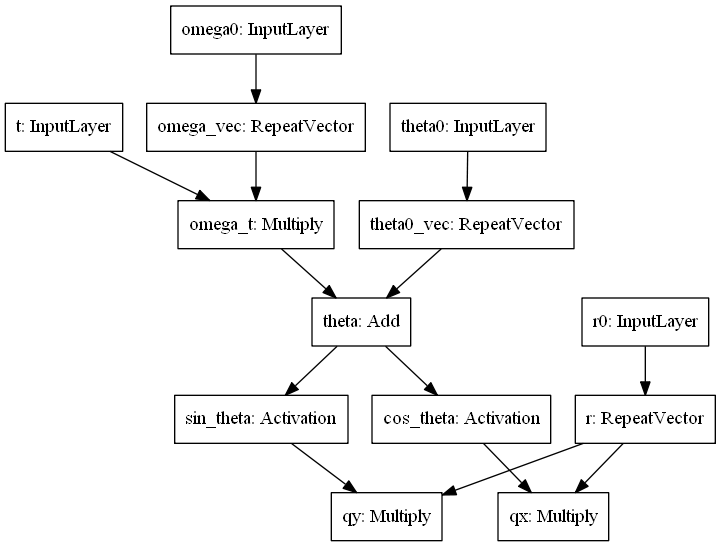

In [25]:
pos_model = make_position_model_r2bc_math(731)
keras.utils.plot_model(pos_model)

In [26]:
pos_model.summary()

Model: "model_r2bc_math"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
omega0 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
omega_vec (RepeatVector)        (None, 731, 1)       0           omega0[0][0]                     
__________________________________________________________________________________________________
t (InputLayer)                  [(None, 731)]        0                                            
__________________________________________________________________________________________________
theta0 (InputLayer)             [(None, 1)]          0                                            
____________________________________________________________________________________

In [27]:
class Motion_R2B(keras.Model):
    """Motion for restricted two body problem generated from a position calculation model."""

    def __init__(self, position_model, **kwargs):
        super(Motion_R2B, self).__init__(**kwargs)
        self.position_model = position_model

    def call(self, inputs):
        """
        Compute full orbits for the restricted two body problem.
        Computes positions using the passed position_layer, 
        then uses automatic differentiation for velocity v and acceleration a.
        INPUTS:
            t: the times to report the orbit; shape (batch_size, traj_size)
            r0: the initial distance; shape (batch_size, 1)
            theta0: the initial angle; shape (batch_size, 1)
            omega0: the angular velocity; shape (batch_size, 1)
        OUTPUTS:
            q: the position at time t; shape (batch_size, traj_size, 2)
            v: the velocity at time t; shape (batch_size, traj_size, 2)
            a: the acceleration at time t; shape (batch_size, traj_size, 2)
        """
        # Unpack time from first input; the rest are passed as-is to position_layer
        t = inputs[0]

        # Get the trajectory size and target shape of t
        traj_size = t.shape[1]
        target_shape = (traj_size, 1)

        # Reshape t to have shape (batch_size, traj_size, 1)
        t = keras.layers.Reshape(target_shape=target_shape, name='t')(t)

        # Evaluation of the position is under the scope of two gradient tapes
        # These are for velocity and acceleration
        with tf.GradientTape(persistent=True) as gt2:
            gt2.watch(t)
        
            with tf.GradientTape(persistent=True) as gt1:
                gt1.watch(t)       
        
                # Get the position using the input position layer
                # qx, qy = self.position_layer([t, r0, theta0, omega0])
                position_inputs = [t] + inputs[1:]
                qx, qy = self.position_model(position_inputs)
                q = keras.layers.concatenate(inputs=[qx, qy], axis=-1, name='q')

            # Compute the velocity v = dq/dt with gt1
            vx = gt1.gradient(qx, t)
            vy = gt1.gradient(qy, t)
            v = keras.layers.concatenate(inputs=[vx, vy], name='v')
            del gt1
            
        # Compute the acceleration a = d2q/dt2 = dv/dt with gt2
        ax = gt2.gradient(vx, t)
        ay = gt2.gradient(vy, t)
        a = keras.layers.concatenate(inputs=[ax, ay], name='a')
        del gt2
            
        return q, v, a

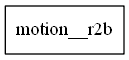

In [28]:
motion_model = Motion_R2B(position_model = pos_model)
keras.utils.plot_model(motion_model)

In [29]:
q, v, a = motion_model([t, r0, theta0, omega0])
print('shape of motion_model outputs:')
print(f'q: {q.shape}')
print(f'v: {v.shape}')
print(f'a: {a.shape}')

shape of motion_model outputs:
q: (64, 731, 2)
v: (64, 731, 2)
a: (64, 731, 2)


In [30]:
def make_model_r2b(position_model: keras.Model, traj_size: int):
    """Create a model for the restricted two body problem"""
    # Create input layers
    t = keras.Input(shape=(traj_size,), name='t')
    q0 = keras.Input(shape=(2,), name='q0')
    v0 = keras.Input(shape=(2,), name='v0')
    mu = keras.Input(shape=(1,), name='mu')
    # The combined input layers
    inputs = [t, q0, v0, mu]

    # Return row 0 of a position or velocity for q0_rec and v0_rec
    initial_row_func = lambda q : q[:, 0, :]

    # The polar coordinates of the initial conditions
    # r0, theta0, and omega0 each scalars in each batch
    r0, theta0, omega0 = ConfigToPolar2D(name='polar0')([q0, v0])
    
    # Name the outputs of the initial polar
    # These each have shape (batch_size, 1)
    r0 = Identity(name='r0')(r0)
    theta0 = Identity(name='theta0')(theta0)
    omega0 = Identity(name='omega0')(omega0)

    # Compute the motion from the specified position layer
    q, v, a = Motion_R2B(position_model=position_model, name='motion')([t, r0, theta0, omega0])
    
    # Name the outputs of the circular motion
    # These each have shape (batch_size, traj_size, 2)
    q = Identity(name='q')(q)
    v = Identity(name='v')(v)
    a = Identity(name='a')(a)

    # Compute q0_rec and v0_rec
    # These each have shape (batch_size, 2)
    q0_rec = keras.layers.Lambda(initial_row_func, name='q0_rec')(q)
    v0_rec = keras.layers.Lambda(initial_row_func, name='v0_rec')(v)

    # Compute kinetic energy T and potential energy U
    T = KineticEnergy_R2B(name='T')(v)
    U = PotentialEnergy_R2B(name='U')([q, mu])
    # Compute the total energy H
    H = keras.layers.add(inputs=[T,U], name='H')

    # Compute angular momentum L
    # This has shape (batch_size, 1)
    L = AngularMomentum_R2B(name='L')([q, v])
    
    # Wrap this up into a model
    outputs = [q, v, a, q0_rec, v0_rec, H, L]
    model = keras.Model(inputs=inputs, outputs=outputs, name='model_math')
    return model

In [31]:
def make_model_r2bc_math(traj_size: int = 731):
    """Create an anlytical model for the restricted two body circular problem"""
    # Build the position model
    position_model = make_position_model_r2bc_math(traj_size=traj_size)
    
    # Build the model with this position layer and the input trajectory size
    return make_model_r2b(position_model=position_model, traj_size=traj_size)

In [32]:
# model_math = make_model_r2bc_math()
model_math = make_model_r2b(position_model=pos_layer, traj_size=traj_size)

In [33]:
# keras.utils.plot_model(model_math)

In [34]:
model_math.summary()

Model: "model_math"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q0 (InputLayer)                 [(None, 2)]          0                                            
__________________________________________________________________________________________________
v0 (InputLayer)                 [(None, 2)]          0                                            
__________________________________________________________________________________________________
polar0 (ConfigToPolar2D)        ((None, 1), (None, 1 0           q0[0][0]                         
                                                                 v0[0][0]                         
__________________________________________________________________________________________________
t (InputLayer)                  [(None, 731)]        0                                   

In [35]:
q.shape

TensorShape([64, 731, 2])

In [36]:
mu.shape

TensorShape([64, 1])

In [37]:
q, v, a, q0_rec, v0_rec, H, L = model_math(batch_in)

In [38]:
optimizer = keras.optimizers.Adam()

loss = {'q': keras.losses.MeanSquaredError(name='q_mse'),
        'v': keras.losses.MeanSquaredError(name='q_mse'),
        'a': keras.losses.MeanSquaredError(name='a_mse')}

metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 0.0}

In [39]:
model_math = make_model_r2bc_math()
model_math.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

W0627 14:59:16.174848  7640 training_utils.py:1237] Output q0_rec missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to q0_rec.
W0627 14:59:16.174848  7640 training_utils.py:1237] Output v0_rec missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to v0_rec.
W0627 14:59:16.174848  7640 training_utils.py:1237] Output H missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to H.
W0627 14:59:16.174848  7640 training_utils.py:1237] Output L missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to L.


In [40]:
# Evaluate the math model on the earth-like data set
model_math.evaluate(ds_solar_val)

32/32 [==============================] - 1s 22ms/step - loss: 1.9813e-12 - q_loss: 1.0436e-12 - v_loss: 9.3764e-13 - a_loss: 1.8915e-10


[1.981277650080736e-12, 1.0436361e-12, 9.376416e-13, 1.8915101e-10]

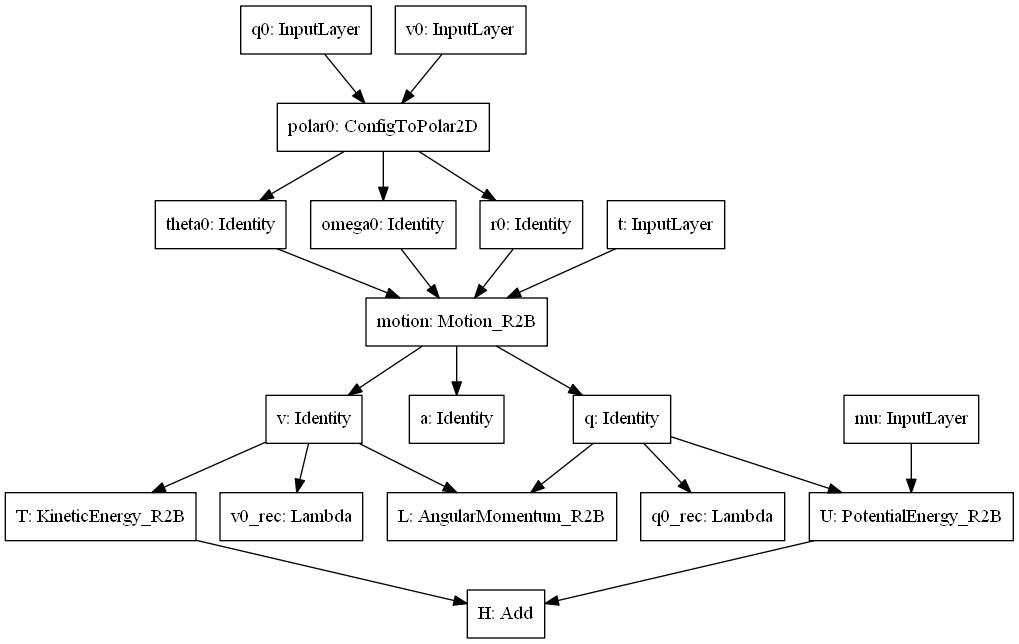

In [41]:
keras.utils.plot_model(model_math, show_shapes=False)

In [42]:
model_math.summary()

Model: "model_math"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q0 (InputLayer)                 [(None, 2)]          0                                            
__________________________________________________________________________________________________
v0 (InputLayer)                 [(None, 2)]          0                                            
__________________________________________________________________________________________________
polar0 (ConfigToPolar2D)        ((None, 1), (None, 1 0           q0[0][0]                         
                                                                 v0[0][0]                         
__________________________________________________________________________________________________
t (InputLayer)                  [(None, 731)]        0                                   

In [43]:
q, v, a, q0_rec, v0_rec, H, L  = model_math([t, q0, v0, mu])
print(f'model output shapes:')
print(f'q = {q.shape}')
print(f'v = {v.shape}')
print(f'a = {a.shape}')
print(f'q0_rec = {q0_rec.shape}')
print(f'v0_rec = {v0_rec.shape}')
print(f'H = {H.shape}')
print(f'L = {L.shape}')

model output shapes:
q = (64, 731, 2)
v = (64, 731, 2)
a = (64, 731, 2)
q0_rec = (64, 2)
v0_rec = (64, 2)
H = (64, 731)
L = (64, 731)


In [44]:
optimizer = keras.optimizers.Adam()

loss = {'q': keras.losses.MeanSquaredError(name='q_mse'),
        'v': keras.losses.MeanSquaredError(name='q_mse'),
        'a': keras.losses.MeanSquaredError(name='a_mse'),
        'q0_rec': keras.losses.MeanSquaredError(name='q0_mse'),
        'v0_rec': keras.losses.MeanSquaredError(name='v0_mse'),
        'H': keras.losses.MeanSquaredError(name='H'),
        'L': keras.losses.MeanSquaredError(name='L')}

# these metrics produce crazy output names when multiple instances share them; hold off for now
# metrics = {'q': keras.metrics.MeanAbsoluteError(name='q_mae'),
#            'v': keras.metrics.MeanAbsoluteError(name='v_mae')}
metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 0.0,
                'q0_rec': 1.0,
                'v0_rec': 1.0,
                'H': 1.0,
                'L': 1.0}

In [45]:
# Compile the mathematical model on a single GPU
model_math = make_model_r2bc_math()
model_math.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [46]:
# Compile the mathematical model for parallel GPUs
# with strat.scope():
#     model_math_par = make_model_r2bc_analytic()
#     model_math_par.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [47]:
# Evaluate the math model on the earth-like data set
model_math.evaluate(ds_solar_val)

32/32 [==============================] - 1s 32ms/step - loss: 1.0412e-11 - q_loss: 1.0436e-12 - v_loss: 9.3764e-13 - a_loss: 1.8915e-10 - q0_rec_loss: 6.6887e-13 - v0_rec_loss: 1.6590e-14 - H_loss: 9.0101e-13 - L_loss: 6.8444e-12


[1.0412165636522301e-11,
 1.0436361e-12,
 9.376416e-13,
 1.8915101e-10,
 6.688697e-13,
 1.6589733e-14,
 9.0101066e-13,
 6.8444174e-12]

In [ ]:
def time_model_eval(model, ds, batches=None, time_mean=None):
    """Time a model to evaluate a dataset"""
    t0 = time.time()
    if batches is None:
        model.evaluate(ds)
    else:
        model.evaluate(ds.take(batches))
    t1 = time.time()
    elapsed = t1 - t0
    print(f'Elapsed Time: {elapsed:5.3f} sec')
    if time_mean is not None:
        delta = (elapsed - time_mean)
        print(f'Time Delta:   {delta:+5.3f} sec')

In [ ]:
# Time the single GPU math model
# time_model_eval(model_math, ds_solar_trn)

In [ ]:
# Time the double GPU math model
# time_model_eval(model_math_par, ds_solar_trn)

In [ ]:
class Position_R2BC_NN(keras.layers.Layer):
    """
    Compute orbit positions for the restricted two body circular problem from 
    the initial polar coordinates (orbital elements) with a neural network.
    """
    def __init__(self, hidden_sizes, skip_layers, **kwargs):
        super(Position_R2BC_NN, self).__init__(**kwargs)
        
        # Network design
        self.hidden_sizes = hidden_sizes
        self.skip_layers = skip_layers

        # Number of hidden layers
        self.num_layers = len(self.hidden_sizes)

    def call(self, inputs):
        """
        INPUTS:
            inputs: a list of the tensors requred.  inputs = [t, r0, theta0, omega0], where
            t: the times to report the orbit; shape (batch_size, traj_size, 1,)
            r0: the initial distance; shape (batch_size, 1,)
            theta0: the initial angle; shape (batch_size, 1,)
            omega0: the angular velocity; shape (batch_size, 1,)
        OUTPUTS:
            qx: the x position at time t; shape (batch_size, traj_size, 1)
            qy: the y position at time t; shape (batch_size, traj_size, 1)
        """
        # Unpack inputs
        t, r0, theta0, omega0 = inputs

        # Get the trajectory size
        traj_size = t.shape[1]

        # Repeat r, theta0 and omega to be vectors of shape matching t
        r = keras.layers.RepeatVector(n=traj_size, name='r')(r0)
        theta0 = keras.layers.RepeatVector(n=traj_size, name='theta0')(theta0)
        omega = keras.layers.RepeatVector(n=traj_size, name='omega')(omega0)

        # The angle theta at time t
        # theta = omega * t + theta0
        omega_t = keras.layers.multiply(inputs=[omega, t], name='omega_t')
        theta = keras.layers.add(inputs=[omega_t, theta0], name='theta')

        # Cosine and sine of theta
        cos_theta = keras.layers.Activation(activation=tf.cos, name='cos_theta')(theta)
        sin_theta = keras.layers.Activation(activation=tf.sin, name='sin_theta')(theta)

        # Compute qx and qy from r, theta
        qx = keras.layers.multiply(inputs=[r, cos_theta], name='qx')
        qy = keras.layers.multiply(inputs=[r, sin_theta], name='qy')
           
        return qx, qy

In [ ]:
def make_model_r2bc_nn(hidden_sizes, skip_layers=True, traj_size: int = 731):
    """Create a neural net model for the restricted two body circular problem"""
    # Build the position layer
    position_layer = Position_R2BC_NN(hidden_sizes=hidden_sizes, skip_layers=skip_layers, name='position_r2bc_nn')
    
    # Build the model with this position layer and the input trajectory size
    return make_model_r2b(position_layer=position_layer, traj_size=traj_size)

In [ ]:
# Make the NN r2bc model
model = make_model_r2bc_nn(hidden_sizes=[64])
model.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [ ]:
# Evaluate the NN model on the earth-like data set
model_math.evaluate(ds_earth_val)

In [ ]:
# Compile the main r2bc model on a single GPU
optimizer = keras.optimizers.Adagrad()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [ ]:
hist = model.fit(ds_earth_trn.repeat(), epochs=10, steps_per_epoch=2000, 
                 validation_data = ds_earth_val, validation_steps=100,
                 callbacks=None)

In [ ]:
# Compile the main model for parallel GPUs
# with strat.scope():
#    model_par = make_model_r2bc()
#    model_par.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [ ]:
# Time the single GPU main model
time_model_eval(model, ds_earth_trn)

In [ ]:
# Time the double GPU main model
# time_model_eval(model_par, ds_earth_trn, batches=1024)

In [ ]:
# keras.utils.plot_model(model, show_shapes=False)

In [ ]:
# Example batch
batch = list(ds_earth_trn.take(1))[0]
batch_in, batch_out = batch
batch_in.keys()

In [ ]:
# filepath = '../models/r2bc_earth_{epoch}.h5'
filepath = '../models/r2bc/model_earth.h5'
callback_ckp = keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_best_only=True,
    monitor='val_loss',
    verbose=1)

log_dir = '../logs/r2bc_earth'
callback_tb = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=0,
    embeddings_freq=0,
    update_freq='epoch')

# Unable to get TensorBoard to work on Windows 10; fails to create new directory
# callbacks = [callback_ckp, callback_tb, TimeHistory()]
callbacks = [TimeHistory()]

In [ ]:
history_earth = model.fit(ds_earth_trn, epochs=10, callbacks=None, validation_data = ds_earth_val)

In [ ]:
xxx = b1_in['v0'].numpy()
xxx = b1_out['a'].numpy()

In [ ]:
np.std(xxx, axis=0)

In [ ]:
np.min(xxx, axis=0)

In [ ]:
np.max(xxx, axis=0)

In [ ]:
pred = model_math.predict(batch_in)
t, q0, v0 = batch_in['t'], batch_in['q0'], batch_in['v0']
q, v, a, q0, v0 = pred

In [ ]:
batch_in.keys()

In [ ]:
q.shape